In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import pyreadstat  ##conda install conda-forge::pyreadstat
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#----------------------------------
# Mass appraisal functions
#----------------------------------

def weightedMean(pred, sp):
    '''
    Returns the weighted mean ratio
    
        Parameters:
            pred (pandas.Series): Series of predicted values
            sp   (pandas.Series): Series of sale prices
            
        Returns:
            weighted mean (numpy.float64): Weighted mean ratio
            
    '''
    return pred.sum() / sp.sum()

def averageDeviation(pred, sp):
    '''
    Returns the average deviation
    
        Parameters:
            pred (pandas.Series): Series of predicted values
            sp   (pandas.Series): Series of sale prices
            
        Returns:
            average deviation (numpy.float64): Average difference between each value
            
    '''
    medianRatio = (pred / sp).median()
    return ((pred / sp) - medianRatio).abs().sum() / len(sp) 

def COD(pred, sp):
    '''
    Returns the coefficient of dispersion
    
        Parameters:
            pred (pandas.Series): Series of predicted values
            sp   (pandas.Series): Series of sale prices
            
        Returns:
            coefficient of dispersion (numpy.float64): Average deviation as a percentage
            
    '''
    medianRatio = (pred / sp).median()
    return (100.00 * averageDeviation(pred, sp)) / medianRatio

def PRD(pred, sp):
    '''
    Returns the price related differential
    
        Parameters:
            pred (pandas.Series): Series of predicted values
            sp   (pandas.Series): Series of sale prices
            
        Returns:
            price related differential (numpy.float64): Statistic for measuring assessment regressivity
            
    '''
    meanRatio = (pred / sp).mean()
    return meanRatio / weightedMean(pred, sp)

def PRB(pred, sp, showGraph=False):
    '''
    Returns the price related bias
    
        Parameters:
            pred (pandas.Series): Series of predicted values
            sp   (pandas.Series): Series of sale prices
            
        Returns:
            price related bias results (dict): Dictionary containing the PRB statistic and it's significance
            
    '''
    RATIO = pred / sp
    medianRatio = (RATIO).median()
    VALUE = (0.50 * sp) + (0.50 * pred / pred.median())
    LN_VALUE = np.log(VALUE) / np.log(2)
    PCT_DIFF = (RATIO - medianRatio) / medianRatio
    modelData = sm.add_constant(LN_VALUE)
    model = sm.OLS(PCT_DIFF, modelData).fit()
    if showGraph:
        p = sns.lmplot(x='LN_VALUE', y='PCT_DIFF', data = pd.DataFrame.from_dict({"LN_VALUE" : LN_VALUE, "PCT_DIFF" : PCT_DIFF}), lowess = True, line_kws={'color': 'red'})
        p.fig.set_figwidth(10)
        p.fig.set_figheight(6)
        p.ax.ticklabel_format(useOffset=False)
    return {"PRB" : model.params[0], "Sig" : model.pvalues[0]}


In [3]:
def addContinuous(df, series, columnName):
    if (series.eq(0).any()):
        s = pd.Series(np.log(series + 1), name = columnName)
    else:
        s = pd.Series(np.log(series), name = columnName)
    return pd.concat([df, s], axis = 1)

def addBinaries(df, categorical, base, prefix, minSales = 0):
    cols = pd.get_dummies(categorical, prefix = prefix).astype(float)
    cols.drop(base, axis = 1, inplace = True)
    for x in cols:
        if len(cols.loc[cols[x] == 1, x]) < minSales:
            print("Insufficent Sales: " + x)
            cols.drop(x, axis = 1, inplace = True)
           
    return pd.concat([df, cols], axis = 1)

# This function dynamically builds a prediction statement
# from the model parameters.  A const param entry is expected.
def estimateParcelValue(predData, modelParams):
    s = "lambda x: " + str(modelParams['const'])
    
    for i,c in modelParams.drop('const').items():
        s += " + (" + str(c) + " * x['" + str(i) + "'])" 
    
    f = eval(s)
    return np.exp(predData.apply(f, axis = 1)).round(0)

# Calculates model coverage by parameters
# with optional grouping
def getParameterCoverage(df):
    results = pd.Series(name = 'ParameterCoverage')
    
    for col in df.columns:
        if len(df[col].value_counts()) == 2:
            #It's a Binary
            results[col] = len(df[df[col] == 1])                
        else:
            #It's Continuous
            results[col] = len(df[df[col] != 0])
                
    return results

In [13]:
data = pd.read_spss('..\\SPSS\\Data\\GISValTechSampleData.sav')
data['ParcelId'] = data['ParcelId'].astype(int)
data['SaleDate'] = pd.to_datetime(data['SaleDate'])
data['SalesPrice'] = data['SalesPrice'].astype(int)
data['Sqft'] = data['Sqft'].astype(int)
data['LandSize'] = data['LandSize'].astype(int)
data['Quality'] = pd.Categorical(data['Quality'], ordered = True, categories = [
     'Poor', 'BelowAverage', 'Average', 'AboveAverage', 'Superior'])
data['GarageSize'] = data['GarageSize'].astype(int)
data['EffAge'] = data['EffAge'].astype(int)
data['NBHD'] = pd.Categorical(data['NBHD'].astype(int))

# data.set_index('ParcelId', inplace = True)
data.sample(8)
#data.dtypes

ParcelId               int32
SaleDate      datetime64[ns]
SalesPrice             int32
Sqft                   int32
LandSize               int32
Bathrooms            float64
Quality             category
GarageSize             int32
EffAge                 int32
NBHD                category
dtype: object

In [16]:
data['SPPSF'] = data['SalesPrice'] / data['Sqft']
#data.groupby(['Quality'], observed = True)['SPPSF'].describe()
data.groupby(['Quality'], observed = True)['SPPSF'].aggregate(['count', 'mean', 'median', 'std' ]).round(2)

,count,mean,median,std
Quality,,,,
Poor,64,122.98,119.45,28.16
BelowAverage,247,146.91,145.21,30.35
Average,271,185.38,184.99,31.99
AboveAverage,180,241.81,238.67,35.12
Superior,60,307.28,299.38,39.98


In [17]:
data.groupby(['NBHD'], observed = True)['SPPSF'].aggregate(['count', 'mean', 'median', 'std' ])

,count,mean,median,std
NBHD,,,,
101,137,116.695077,114.362734,20.943218
102,215,166.801041,161.984105,30.758226
103,258,191.348178,187.546034,33.471539
104,124,239.150479,237.894661,37.336202
105,88,289.602511,289.527589,45.697791


In [19]:
data['SYEAR'] = data['SaleDate'].dt.year
data['SMONTH'] = data['SaleDate'].dt.month
data['SDATE'] = data['SaleDate'].dt.to_period('M').dt.to_timestamp()
pd.crosstab(data['SYEAR'], data['SMONTH'])
data

,ParcelId,SaleDate,SalesPrice,Sqft,LandSize,Bathrooms,Quality,GarageSize,EffAge,NBHD,SPPSF,SYEAR,SMONTH,SDATE
0,103525,2023-01-01,254596,1573,27325,2.5,BelowAverage,360,41,102,161.853783,2023,1,2023-01-01
1,110784,2023-01-01,1151736,4586,14157,5.0,AboveAverage,484,18,105,251.141736,2023,1,2023-01-01
2,116454,2023-01-01,501824,2548,17156,3.5,Average,384,10,103,196.948195,2023,1,2023-01-01
3,138782,2023-01-02,789205,3312,34341,2.5,AboveAverage,360,16,104,238.286534,2023,1,2023-01-01
4,102652,2023-01-03,548042,2455,34412,2.5,AboveAverage,484,55,104,223.235031,2023,1,2023-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
817,111457,2023-12-27,197658,1576,20188,2.5,Poor,360,58,102,125.417513,2023,12,2023-12-01
818,109969,2023-12-28,322208,1493,22137,3.0,BelowAverage,264,29,102,215.812458,2023,12,2023-12-01
819,113733,2023-12-29,144949,1148,15213,2.0,BelowAverage,0,73,101,126.262195,2023,12,2023-12-01
820,105513,2023-12-30,306441,1551,13181,3.5,BelowAverage,0,31,102,197.576402,2023,12,2023-12-01


In [20]:
startdate = pd.to_datetime('1/1/2023')
basedate = pd.to_datetime('12/31/2023')
timeperiod = (basedate.to_period('M') - startdate.to_period('M')).n
timeperiod

11

In [23]:
data['Months'] = [(x - startdate.to_period('M')).n for x in data['SaleDate'].dt.to_period('M')]
data['Month'] = timeperiod - data['Months']
data.sample(5)


,ParcelId,SaleDate,SalesPrice,Sqft,LandSize,Bathrooms,Quality,GarageSize,EffAge,NBHD,SPPSF,SYEAR,SMONTH,SDATE,Months,Month
276,133666,2023-05-10,550147,2974,11886,3.5,Average,360,22,103,184.985541,2023,5,2023-05-01,4,7
428,111475,2023-07-11,213298,1473,13012,2.0,Average,0,50,101,144.805160,2023,7,2023-07-01,6,5
133,120765,2023-02-11,267938,1814,12495,2.5,BelowAverage,484,24,102,147.705623,2023,2,2023-02-01,1,10
12,134358,2023-01-04,742229,3498,39881,2.5,AboveAverage,484,47,104,212.186678,2023,1,2023-01-01,0,11
813,109503,2023-12-22,427004,2809,12840,2.5,Average,0,50,103,152.012816,2023,12,2023-12-01,11,0


In [24]:
def calculatePctGood(effAge):
    if effAge < 0:
        effAge = 0
    elif effAge > 60:
        effAge = 60    
    return round(1 - (effAge / 100), 2)
        
    
data['Pct_Good'] = [calculatePctGood(x) for x in data['EffAge']]
data[['EffAge', 'Pct_Good']].head()
    

,EffAge,Pct_Good
0,41,0.59
1,18,0.82
2,10,0.90
3,16,0.84
4,55,0.45


In [28]:
modelData = pd.DataFrame({"LN_SalesPrice" : np.log(data['SalesPrice']), "const" : 1})
modelData = pd.concat([modelData, data['Months']], axis = 1 )
modelData = addContinuous(modelData, data['Sqft'], 'LN_Sqft')
modelData = addContinuous(modelData, data['LandSize'], 'LN_LandSize')
modelData = addBinaries(modelData, data['Quality'], 'Quality_Average', 'Quality', minSales = 6)
modelData = addContinuous(modelData, data['Bathrooms'], 'LN_Bathrooms')
modelData = addContinuous(modelData, data['Pct_Good'], 'LN_Pct_Good')
modelData = addContinuous(modelData, data['GarageSize'], 'LN_GarageSize')
# #modelData = addContinuous(modelData, data['GarageSize'] / 480, 'LN_GarageSize_Ratio')
modelData = addBinaries(modelData, data['NBHD'], 'NBHD_103', 'NBHD', minSales = 6)
modelData

,LN_SalesPrice,const,Months,LN_Sqft,LN_LandSize,Quality_Poor,Quality_BelowAverage,Quality_AboveAverage,Quality_Superior,LN_Bathrooms,LN_Pct_Good,LN_GarageSize,NBHD_101,NBHD_102,NBHD_104,NBHD_105
0,12.447433,1,0,7.360740,10.215557,0.0,1.0,0.0,0.0,0.916291,-0.527633,5.888878,0.0,1.0,0.0,0.0
1,13.956781,1,0,8.430763,9.557964,0.0,0.0,1.0,0.0,1.609438,-0.198451,6.184149,0.0,0.0,0.0,1.0
2,13.126005,1,0,7.843064,9.750103,0.0,0.0,0.0,0.0,1.252763,-0.105361,5.953243,0.0,0.0,0.0,0.0
3,13.578781,1,0,8.105308,10.444095,0.0,0.0,1.0,0.0,0.916291,-0.174353,5.888878,0.0,0.0,1.0,0.0
4,13.214107,1,0,7.805882,10.446161,0.0,0.0,1.0,0.0,0.916291,-0.798508,6.184149,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
817,12.194294,1,11,7.362645,9.912844,1.0,0.0,0.0,0.0,0.916291,-0.867501,5.888878,0.0,1.0,0.0,0.0
818,12.682953,1,11,7.308543,10.005006,0.0,1.0,0.0,0.0,1.098612,-0.342490,5.579730,0.0,1.0,0.0,0.0
819,11.884137,1,11,7.045777,9.629906,0.0,1.0,0.0,0.0,0.693147,-0.916291,0.000000,1.0,0.0,0.0,0.0
820,12.632781,1,11,7.346655,9.486532,0.0,1.0,0.0,0.0,1.252763,-0.371064,0.000000,0.0,1.0,0.0,0.0


In [31]:
# This assumes dependent variable is in the first column
while True:
    model = sm.OLS(
        modelData.iloc[:, 0],
        modelData.drop(modelData.columns[0], axis = 1)
    ).fit()
    ix = model.pvalues[model.pvalues.index != 'const'].idxmax()
    if(model.pvalues[ix] <= .05):
        break
    else:
        print("Dropping {0} p-value: {1} ".format(str(ix), model.pvalues[ix].round(3)))
        modelData.drop(columns = ix, inplace = True)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          LN_SalesPrice   R-squared:                       0.966
Model:                            OLS   Adj. R-squared:                  0.966
Method:                 Least Squares   F-statistic:                     1772.
Date:                Thu, 11 Apr 2024   Prob (F-statistic):               0.00
Time:                        14:58:41   Log-Likelihood:                 543.87
No. Observations:                 822   AIC:                            -1060.
Df Residuals:                     808   BIC:                            -993.8
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    4.9914      0.263     18.952      0.000       4.474       5.508
Months                   0.0103      0.001      7.995      0.000       0.008       0.013
LN_Sqft                  0.9344      0.021     43.806      0.000       0.892       0.976
LN_LandSize              0.0696      0.018      3.763      0.000       0.033       0.106
Quality_Poor            -0.2559      0.020    -12.545      0.000      -0.296      -0.216
Quality_BelowAverage    -0.1612      0.013    -12.121      0.000      -0.187      -0.135
Quality_AboveAverage     0.1728      0.014     12.247      0.000       0.145       0.200
Quality_Superior         0.3523      0.024     14.866      0.000       0.306       0.399
LN_Bathrooms             0.0710      0.026      2.784      0.006       0.021       0.121
LN_Pct_Good              0.2525      0.019     13.145      0.000       0.215       0.290
LN_GarageSize            0.0072      0.002      3.363      0.001       0.003       0.011
NBHD_101                -0.2235      0.019    -11.758      0.000      -0.261      -0.186
NBHD_104                 0.0681      0.020      3.368      0.001       0.028       0.108
NBHD_105                 0.1129      0.029      3.939      0.000       0.057       0.169
==============================================================================
Omnibus:                       22.223   Durbin-Watson:                   1.974
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               23.407
Skew:                          -0.389   Prob(JB):                     8.27e-06
Kurtosis:                       3.281   Cond. No.                         867.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [34]:
# show all methods and functions of an object
dir(model)

['HC0_se',
 'HC1_se',
 'HC2_se',
 'HC3_se',
 '_HCCM',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abat_diagonal',
 '_cache',
 '_data_attr',
 '_data_in_cache',
 '_get_robustcov_results',
 '_get_wald_nonlinear',
 '_is_nested',
 '_transform_predict_exog',
 '_use_t',
 '_wexog_singular_values',
 'aic',
 'bic',
 'bse',
 'centered_tss',
 'compare_f_test',
 'compare_lm_test',
 'compare_lr_test',
 'condition_number',
 'conf_int',
 'conf_int_el',
 'cov_HC0',
 'cov_HC1',
 'cov_HC2',
 'cov_HC3',
 'cov_kwds',
 'cov_params',
 'cov_type',
 'df_model',
 'df_resid',
 'diagn',
 'eigenvals',
 'el_test',
 'ess',
 'f_pvalue',
 'f_test',
 'fittedvalues',
 'fvalue',
 '

In [32]:
model.params

const                   4.991421
Months                  0.010282
LN_Sqft                 0.934356
LN_LandSize             0.069569
Quality_Poor           -0.255861
Quality_BelowAverage   -0.161182
Quality_AboveAverage    0.172783
Quality_Superior        0.352297
LN_Bathrooms            0.071049
LN_Pct_Good             0.252519
LN_GarageSize           0.007184
NBHD_101               -0.223483
NBHD_104                0.068102
NBHD_105                0.112873
dtype: float64

In [35]:
model.df_resid

808.0

In [36]:
getParameterCoverage(modelData)

LN_SalesPrice           822
const                   822
Months                  704
LN_Sqft                 822
LN_LandSize             822
Quality_Poor             64
Quality_BelowAverage    247
Quality_AboveAverage    180
Quality_Superior         60
LN_Bathrooms            822
LN_Pct_Good             812
LN_GarageSize           601
NBHD_101                137
NBHD_104                124
NBHD_105                 88
Name: ParameterCoverage, dtype: int64

In [37]:
data['ESP'] = estimateParcelValue(modelData, model.params ).astype(int)
data['Ratio'] = round((data['ESP'] / data['SalesPrice']), 2)
data.head()

,ParcelId,SaleDate,SalesPrice,Sqft,LandSize,Bathrooms,Quality,GarageSize,EffAge,NBHD,SPPSF,SYEAR,SMONTH,SDATE,Months,Month,Pct_Good,ESP,Ratio
0,103525,2023-01-01,254596,1573,27325,2.5,BelowAverage,360,41,102,161.853783,2023,1,2023-01-01,0,11,0.59,241023,0.95
1,110784,2023-01-01,1151736,4586,14157,5.0,AboveAverage,484,18,105,251.141736,2023,1,2023-01-01,0,11,0.82,1119078,0.97
2,116454,2023-01-01,501824,2548,17156,3.5,Average,384,10,103,196.948195,2023,1,2023-01-01,0,11,0.90,490467,0.98
3,138782,2023-01-02,789205,3312,34341,2.5,AboveAverage,360,16,104,238.286534,2023,1,2023-01-01,0,11,0.84,802524,1.02
4,102652,2023-01-03,548042,2455,34412,2.5,AboveAverage,484,55,104,223.235031,2023,1,2023-01-01,0,11,0.45,519385,0.95


{'PRB': -0.02525227919748191, 'Sig': 3.986456673710953e-08}

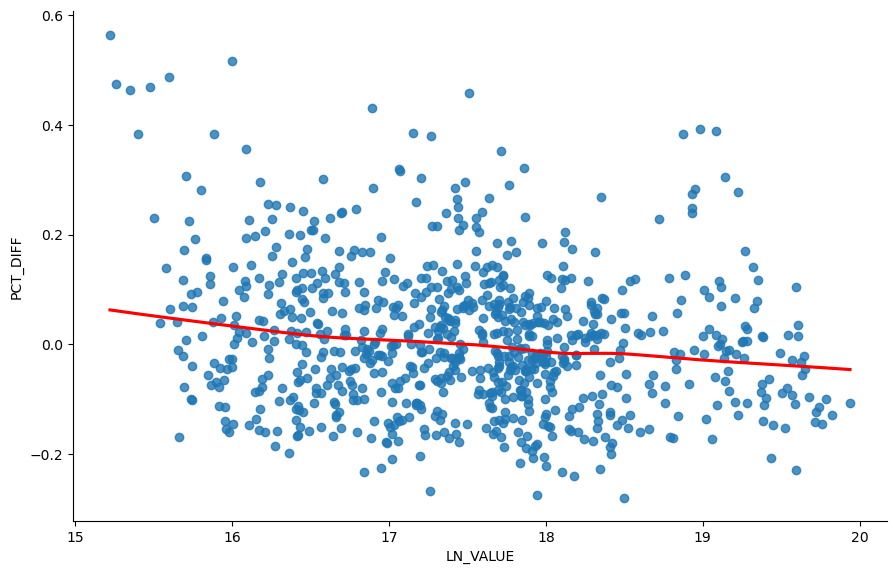

In [38]:
PRB(data['ESP'], data['SalesPrice'], showGraph = True)

In [39]:
stats = pd.DataFrame(columns = ['Count', 'Mean', 'Median', 'WgtMean', 'Min', 'Max', 'PRD', 'COD'])
for name, gData in data.groupby(by='NBHD', observed = True):
    stats.loc[name] = [
        len(gData.index),
        '%0.2f' % gData['Ratio'].mean(),
        '%0.2f' % gData['Ratio'].median(),
        '%0.2f' % weightedMean(gData['ESP'], gData['SalesPrice']),
        gData['Ratio'].min(),
        gData['Ratio'].max(),
        '%0.2f' % PRD(gData['ESP'], gData['SalesPrice']),
        '%0.2f' % COD(gData['ESP'], gData['SalesPrice'])
    ]

stats

,Count,Mean,Median,WgtMean,Min,Max,PRD,COD
101,137,1.01,0.99,0.99,0.73,1.56,1.02,12.05
102,215,1.01,1.00,1.00,0.77,1.51,1.02,9.87
103,258,1.00,0.99,0.99,0.72,1.43,1.01,9.49
104,124,1.01,1.01,1.00,0.77,1.45,1.01,9.03
105,88,1.01,0.98,0.99,0.77,1.39,1.01,10.02


In [40]:
stats = pd.DataFrame(columns = ['Count', 'Mean', 'Median', 'WgtMean', 'Min', 'Max', 'PRD', 'COD'])
for name, gData in data.groupby(by='SDATE', observed = True):
    stats.loc[name.strftime('%b %Y')] = [
        len(gData.index),
        '%0.2f' % gData['Ratio'].mean(),
        '%0.2f' % gData['Ratio'].median(),
        '%0.2f' % weightedMean(gData['ESP'], gData['SalesPrice']),
        gData['Ratio'].min(),
        gData['Ratio'].max(),
        '%0.2f' % PRD(gData['ESP'], gData['SalesPrice']),
        '%0.2f' % COD(gData['ESP'], gData['SalesPrice'])
    ]

stats

,Count,Mean,Median,WgtMean,Min,Max,PRD,COD
Jan 2023,118,0.98,0.96,0.97,0.72,1.51,1.02,10.67
Feb 2023,33,1.06,1.06,1.00,0.77,1.46,1.06,10.59
Mar 2023,40,1.02,1.01,1.00,0.77,1.48,1.02,10.34
Apr 2023,53,1.00,0.98,0.99,0.79,1.29,1.02,9.00
May 2023,87,1.02,1.01,1.02,0.72,1.38,1.01,10.29
Jun 2023,82,1.02,1.01,1.02,0.83,1.28,1.00,7.71
Jul 2023,76,1.00,0.97,0.99,0.77,1.56,1.01,9.82
Aug 2023,71,1.01,1.02,1.00,0.73,1.39,1.01,10.03
Sep 2023,70,1.00,0.99,0.98,0.76,1.35,1.02,9.08
Oct 2023,61,1.02,1.00,1.00,0.79,1.47,1.02,10.81


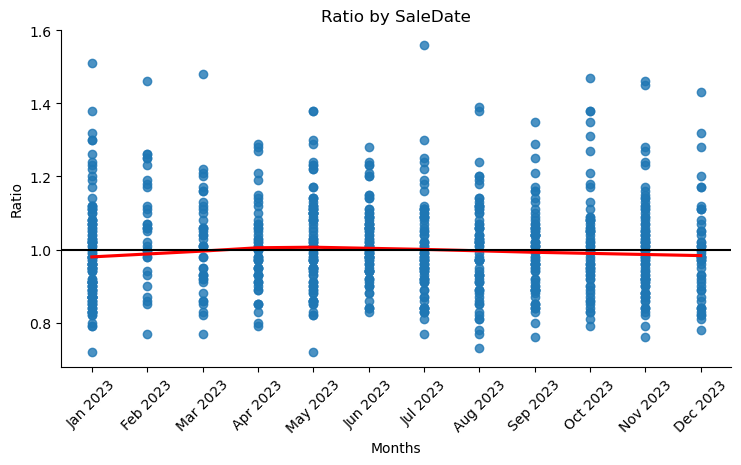

In [45]:
p = sns.lmplot(x='Months', y='Ratio', data = data, lowess = True, line_kws={'color': 'red'})
p.fig.set_figwidth(8)
p.fig.set_figheight(4)
p.ax.set_title("Ratio by SaleDate")
p.ax.ticklabel_format(useOffset=False)
label = [x.strftime('%b %Y') for x in data.sort_values(by='SaleDate')["SDATE"].unique()]
p.ax.set_xticks(range(len(label)), labels=label)
p.ax.tick_params(axis="x", labelrotation=45)
plt.axhline(y=1.00, color = 'black')

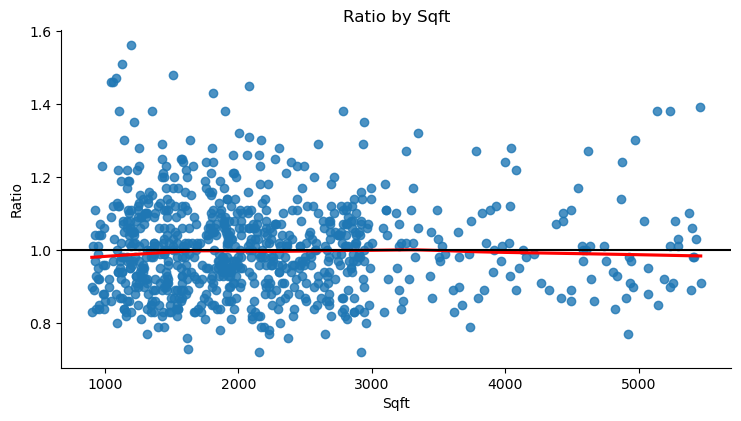

In [46]:
p = sns.lmplot(x='Sqft', y='Ratio', data = data, lowess = True, line_kws={'color': 'red'})
p.fig.set_figwidth(8)
p.fig.set_figheight(4)
p.ax.set_title("Ratio by Sqft")
p.ax.ticklabel_format(useOffset=False)
plt.axhline(y=1.00, color = 'black')

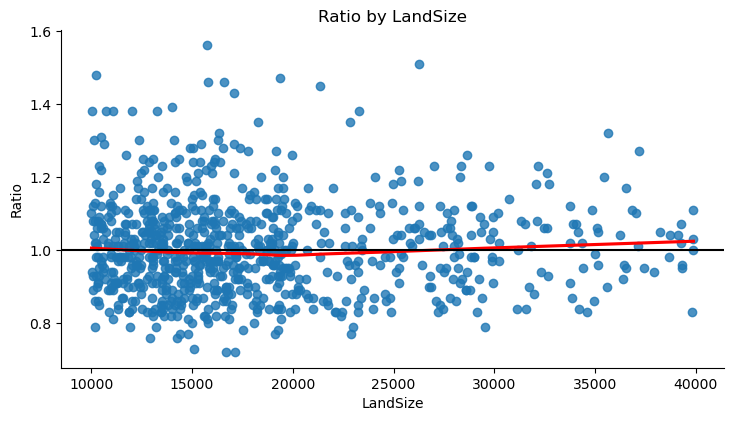

In [47]:
p = sns.lmplot(x='LandSize', y='Ratio', data = data, lowess = True, line_kws={'color': 'red'})
p.fig.set_figwidth(8)
p.fig.set_figheight(4)
p.ax.set_title("Ratio by LandSize")
p.ax.ticklabel_format(useOffset=False)
plt.axhline(y=1.00, color = 'black')

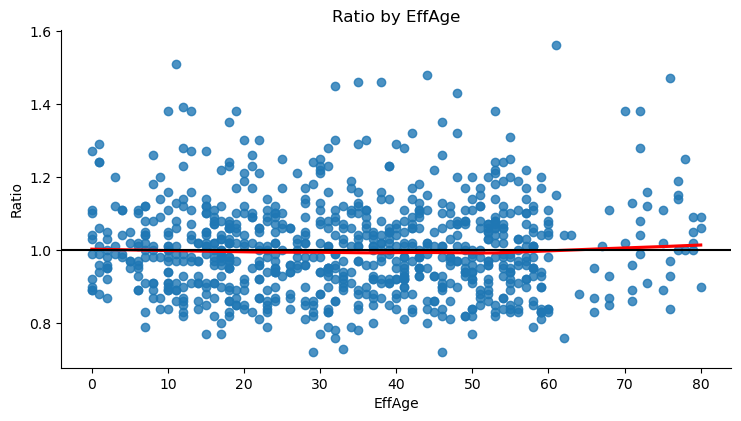

In [48]:
p = sns.lmplot(x='EffAge', y='Ratio', data = data, lowess = True, line_kws={'color': 'red'})
p.fig.set_figwidth(8)
p.fig.set_figheight(4)
p.ax.set_title("Ratio by EffAge")
p.ax.ticklabel_format(useOffset=False)
plt.axhline(y=1.00, color = 'black')

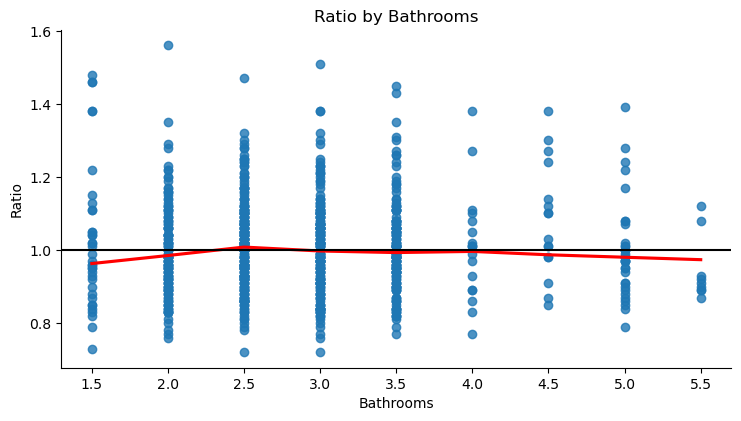

In [49]:
p = sns.lmplot(x='Bathrooms', y='Ratio', data = data, lowess = True, line_kws={'color': 'red'})
p.fig.set_figwidth(8)
p.fig.set_figheight(4)
p.ax.set_title("Ratio by Bathrooms")
p.ax.ticklabel_format(useOffset=False)
plt.axhline(y=1.00, color = 'black')

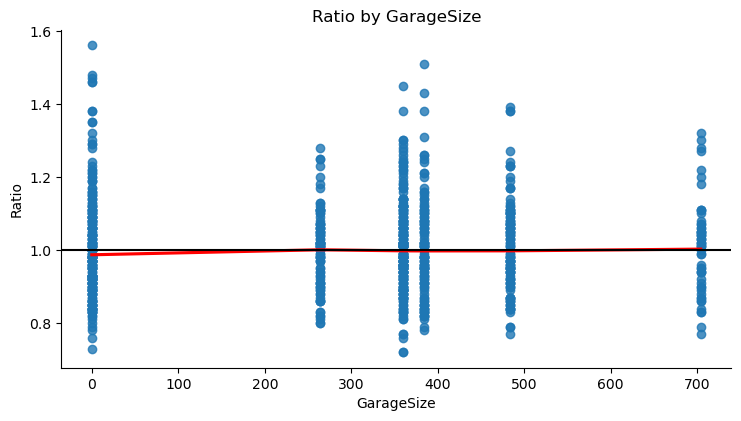

In [50]:
p = sns.lmplot(x='GarageSize', y='Ratio', data = data, lowess = True, line_kws={'color': 'red'})
p.fig.set_figwidth(8)
p.fig.set_figheight(4)
p.ax.set_title("Ratio by GarageSize")
p.ax.ticklabel_format(useOffset=False)
plt.axhline(y=1.00, color = 'black')

In [51]:
data.groupby('Quality', observed=True)['Ratio'].describe()

,count,mean,std,min,25%,50%,75%,max
Quality,,,,,,,,
Poor,64.0,1.010156,0.154760,0.77,0.9200,0.985,1.09,1.56
BelowAverage,247.0,1.008138,0.130726,0.76,0.9100,1.000,1.09,1.51
Average,271.0,1.008376,0.131691,0.72,0.9200,0.990,1.08,1.43
AboveAverage,180.0,1.006611,0.117683,0.77,0.9200,1.000,1.07,1.45
Superior,60.0,1.006500,0.125223,0.79,0.9075,0.995,1.06,1.38


In [52]:
data.loc[(data['Ratio'] >= 1.5) | (data['Ratio'] <= .65), ]

,ParcelId,SaleDate,SalesPrice,Sqft,LandSize,Bathrooms,Quality,GarageSize,EffAge,NBHD,SPPSF,SYEAR,SMONTH,SDATE,Months,Month,Pct_Good,ESP,Ratio
44,119180,2023-01-13,130975,1127,26275,3.0,BelowAverage,384,11,102,116.215617,2023,1,2023-01-01,0,11,0.89,197919,1.51
485,105323,2023-07-31,76438,1200,15718,2.0,Poor,0,61,101,63.698333,2023,7,2023-07-01,6,5,0.40,119194,1.56


In [53]:
data.loc[(data['Ratio'] >= 1.5) | (data['Ratio'] <= .65), ].to_excel('.\\reports\\multiplicativebadratio.xlsx')